# Random search and hyperparameter scaling with SageMaker XGBoost and Automatic Model Tuning

---

## Contents

1. [Introduction](#Introduction)
1. [Preparation](#Preparation)
1. [Download and prepare the data](#Download-and-prepare-the-data)
1. [Setup hyperparameter tuning](#Setup-hyperparameter-tuning)
1. [Logarithmic scaling](#Logarithmic-scaling)
1. [Random search](#Random-search)
1. [Linear scaling](#Linear-scaling)


---

## Introduction

This notebook showcases the use of two hyperparameter tuning features: **random search** and **hyperparameter scaling**.


We will use SageMaker Python SDK, a high level SDK, to simplify the way we interact with SageMaker Hyperparameter Tuning.

---

## Preparation

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as SageMaker training.
- The IAM role used to give training access to your data. See SageMaker documentation for how to create these.

In [17]:
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import os

region = boto3.Session().region_name
smclient = boto3.Session().client("sagemaker")

role = sagemaker.get_execution_role()

bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-hpo-xgboost-dm"

---

## Download and prepare the data
Here we download the [direct marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) from UCI's ML Repository.

In [18]:
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2021-06-09 21:20:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘bank-additional.zip’ not modified on server. Omitting download.

Archive:  bank-additional.zip
  inflating: bank-additional/.DS_Store  
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


Now let us load the data, apply some preprocessing, and upload the processed data to s3

In [19]:
# Load data
data = pd.read_csv("./bank-additional/bank-additional-full.csv", sep=";")
pd.set_option("display.max_columns", 500)  # Make sure we can see all of the columns
pd.set_option("display.max_rows", 50)  # Keep the output on one page

# Apply some feature processing
data["no_previous_contact"] = np.where(
    data["pdays"] == 999, 1, 0
)  # Indicator variable to capture when pdays takes a value of 999
data["not_working"] = np.where(
    np.in1d(data["job"], ["student", "retired", "unemployed"]), 1, 0
)  # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)  # Convert categorical variables to sets of indicators

# columns that should not be included in the input
model_data = model_data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)

# split data
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

# save preprocessed file to s3
pd.concat([train_data["y_yes"], train_data.drop(["y_no", "y_yes"], axis=1)], axis=1).to_csv(
    "train.csv", index=False, header=False
)
pd.concat(
    [validation_data["y_yes"], validation_data.drop(["y_no", "y_yes"], axis=1)], axis=1
).to_csv("validation.csv", index=False, header=False)
pd.concat([test_data["y_yes"], test_data.drop(["y_no", "y_yes"], axis=1)], axis=1).to_csv(
    "test.csv", index=False, header=False
)
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

In [20]:
# input for SageMaker

from sagemaker.inputs import TrainingInput

s3_input_train = TrainingInput(
    s3_data = "s3://{}/{}/train".format(bucket, prefix), 
    content_type='csv'
)

s3_input_validation = TrainingInput(
    s3_data = "s3://{}/{}/validation".format(bucket, prefix), 
    content_type='csv'
)


---

## Setup hyperparameter tuning
In this example, we are using SageMaker Python SDK to set up and manage the hyperparameter tuning job. We first configure the training jobs the hyperparameter tuning job will launch by initiating an estimator, and define the static hyperparameter and objective

In [21]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve

sess = sagemaker.Session()

container = retrieve("xgboost", region, "latest")

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

xgb.set_hyperparameters(
    eval_metric="auc",
    objective="binary:logistic",
    num_round=10,
    rate_drop=0.3,
    tweedie_variance_power=1.4,
)
objective_metric_name = "validation:auc"

# Logarithmic scaling

In both cases we use logarithmic scaling, which is the scaling type that should be used whenever the order of magnitude is more important that the absolute value. It should be used if a change, say, from 1 to 2 is expected to have a much bigger impact than a change from 100 to 101, due to the fact that the hyperparameter doubles in the first case but not in the latter.

In [22]:
hyperparameter_ranges = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
}

# Random search

We now start a tuning job using random search. The main advantage of using random search is that this allows us to train jobs with a high level of parallelism

In [23]:
tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False
)

....................................................................!


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [24]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

# Linear scaling

Let us compare the results with executing a job using linear scaling.

In [25]:
hyperparameter_ranges_linear = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Linear"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Linear"),
}
tuner_linear = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

# custom job name to avoid a duplicate name
job_name = tuner_log.latest_tuning_job.job_name + "linear"
tuner_linear.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name=job_name,
)

..................................................!


Check of the hyperparameter tuning jobs status

In [26]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

## Analyze tuning job results - after tuning job is completed

**Once the tuning jobs have completed**, we can compare the distribution of the hyperparameter configurations chosen in the two cases.

Please refer to "HPO_Analyze_TuningJob_Results.ipynb" to see more example code to analyze the tuning job results.


In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# check jobs have finished
status_log = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]
status_linear = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

assert status_log == "Completed", "First must be completed, was {}".format(status_log)
assert status_linear == "Completed", "Second must be completed, was {}".format(status_linear)

df_log = sagemaker.HyperparameterTuningJobAnalytics(
    tuner_log.latest_tuning_job.job_name
).dataframe()
df_linear = sagemaker.HyperparameterTuningJobAnalytics(
    tuner_linear.latest_tuning_job.job_name
).dataframe()
df_log["scaling"] = "log"
df_linear["scaling"] = "linear"
df = pd.concat([df_log, df_linear], ignore_index=True)

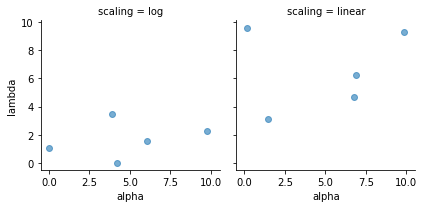

In [28]:
g = sns.FacetGrid(df, col="scaling", palette="viridis")
g = g.map(plt.scatter, "alpha", "lambda", alpha=0.6)

## Deploy the best model

In [41]:
predictor = tuner_linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


2021-06-09 21:29:48 Starting - Preparing the instances for training
2021-06-09 21:29:48 Downloading - Downloading input data
2021-06-09 21:29:48 Training - Training image download completed. Training in progress.
2021-06-09 21:29:48 Uploading - Uploading generated training model
2021-06-09 21:29:48 Completed - Training job completed
------!

## Delete the end point

In [71]:
sess.delete_endpoint(
    endpoint_name = predictor.endpoint_name
)